In [1]:

# ============================
# 1) PARAMETRI & REPRO SETUP
# ============================
from pathlib import Path
RANDOM_STATE = 42
N_FOLDS = 5  # Stratified K-Fold
DATA_PATH = 'Dataset/loan_data.csv'  # <-- MODIFICA con il percorso del tuo CSV
TARGET = 'loan_status'               # <-- MODIFICA se diverso

# Per controllare il carico computazionale delle grid (True=usa HalvingGridSearchCV)
USE_HALVING = False

import numpy as np, pandas as pd, warnings, sys, os, json, math, random
from sklearn import set_config
set_config(transform_output="default")
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
warnings.filterwarnings('ignore')

import sklearn, imblearn, shap
from platform import python_version



In [2]:

# ===================================
# 2) CARICAMENTO DATI & SANITY CHECK
# ===================================
from pathlib import Path
import pandas as pd

path = Path(DATA_PATH)
assert path.exists(), f"File non trovato: {path}"
df = pd.read_csv(path)
print('Shape:', df.shape)
display(df.head(3))
print('\nColonne:', list(df.columns))
print('\nTipi:', df.dtypes.value_counts())


# Info target availability
assert TARGET in df.columns, f"Colonna TARGET '{TARGET}' non trovata"
print('\nTarget value counts (raw):')
print(df[TARGET].value_counts(dropna=False).head(10))# meh

df_work = df.copy()



Shape: (45000, 14)


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1



Colonne: ['person_age', 'person_gender', 'person_education', 'person_income', 'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'previous_loan_defaults_on_file', 'loan_status']

Tipi: float64    6
object     5
int64      3
Name: count, dtype: int64

Target value counts (raw):
loan_status
0    35000
1    10000
Name: count, dtype: int64


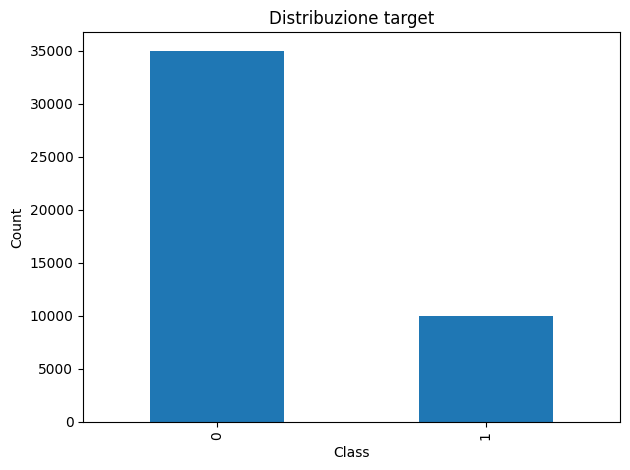

,missing_ratio
person_age,0.0
person_gender,0.0
person_education,0.0
person_income,0.0
person_emp_exp,0.0
person_home_ownership,0.0
loan_amnt,0.0
loan_intent,0.0
loan_int_rate,0.0
loan_percent_income,0.0



Cardinalità variabili categoriche:


,n_unique
loan_intent,6
person_education,5
person_home_ownership,4
person_gender,2
previous_loan_defaults_on_file,2



Statistiche descrittive numeriche:


,count,mean,std,min,25%,50%,75%,max
person_age,45000.0,27.764178,6.045108,20.00,24.00,26.00,30.00,144.00
person_income,45000.0,80319.053222,80422.498632,8000.00,47204.00,67048.00,95789.25,7200766.00
person_emp_exp,45000.0,5.410333,6.063532,0.00,1.00,4.00,8.00,125.00
loan_amnt,45000.0,9583.157556,6314.886691,500.00,5000.00,8000.00,12237.25,35000.00
loan_int_rate,45000.0,11.006606,2.978808,5.42,8.59,11.01,12.99,20.00
loan_percent_income,45000.0,0.139725,0.087212,0.00,0.07,0.12,0.19,0.66
cb_person_cred_hist_length,45000.0,5.867489,3.879702,2.00,3.00,4.00,8.00,30.00
credit_score,45000.0,632.608756,50.435865,390.00,601.00,640.00,670.00,850.00



Correlazione con il target (numeriche):


,corr_with_target
loan_percent_income,0.384880
loan_int_rate,0.332005
loan_amnt,0.107714
credit_score,-0.007647
cb_person_cred_hist_length,-0.014851
person_emp_exp,-0.020481
person_age,-0.021476
person_income,-0.135808


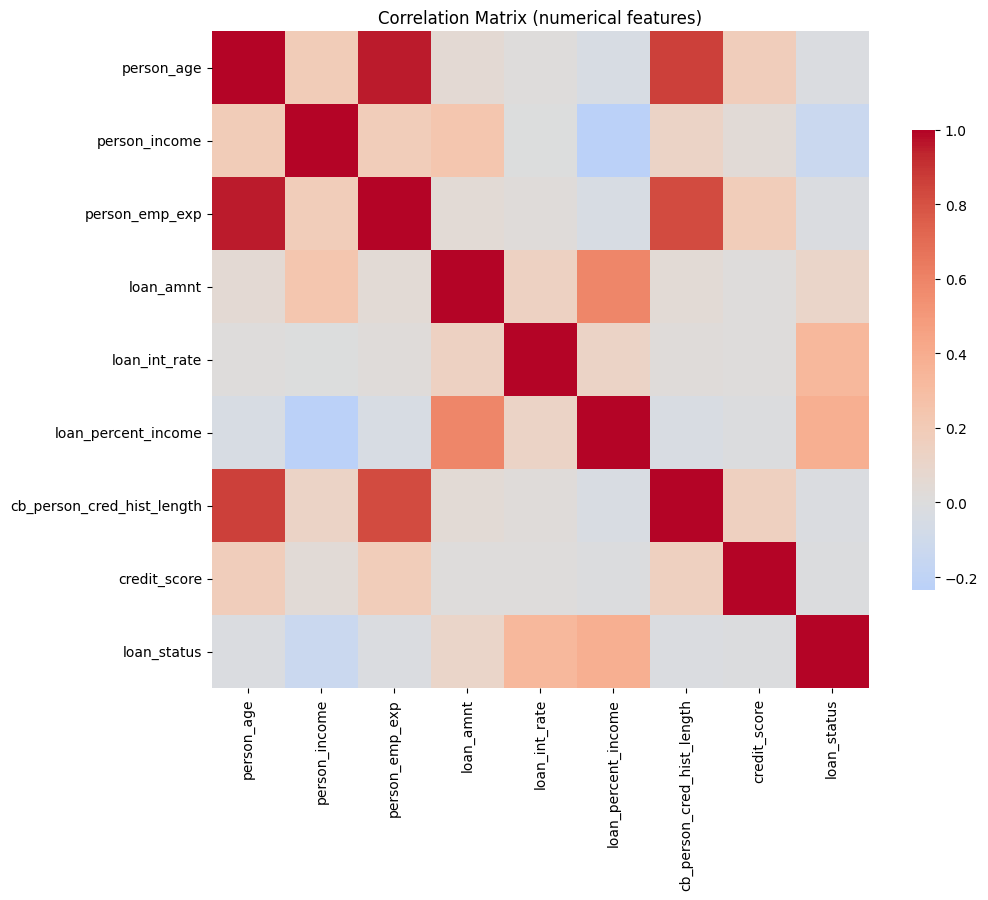

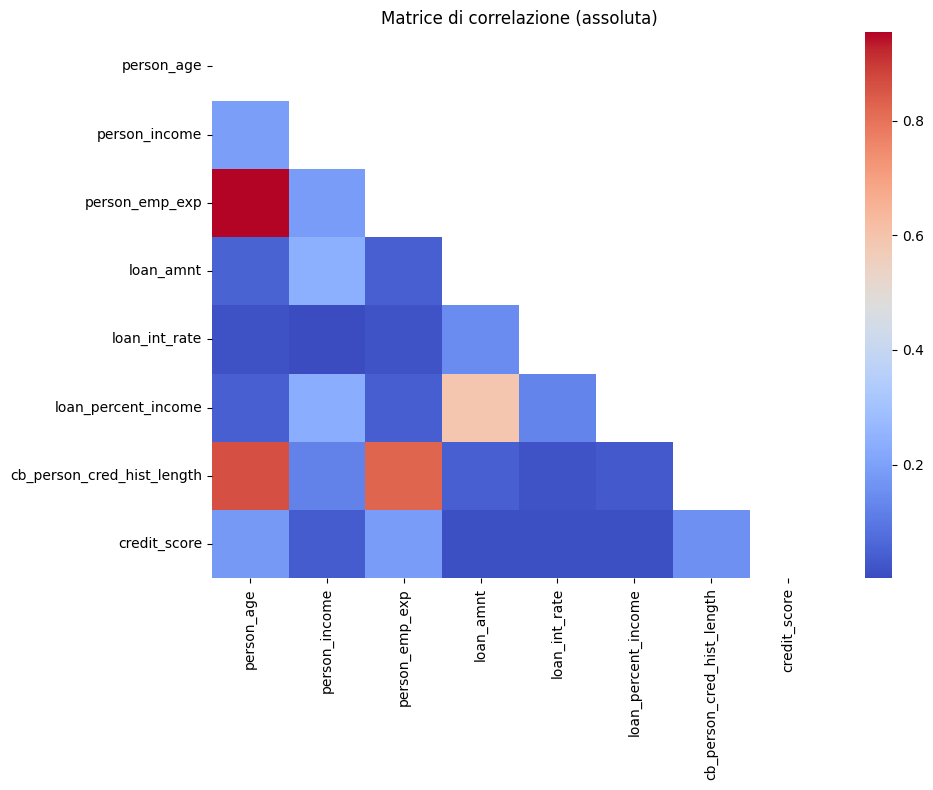


Coppie di feature altamente correlate (|r|>=0.95):


,feat1,feat2,corr
0,person_age,person_emp_exp,0.954412


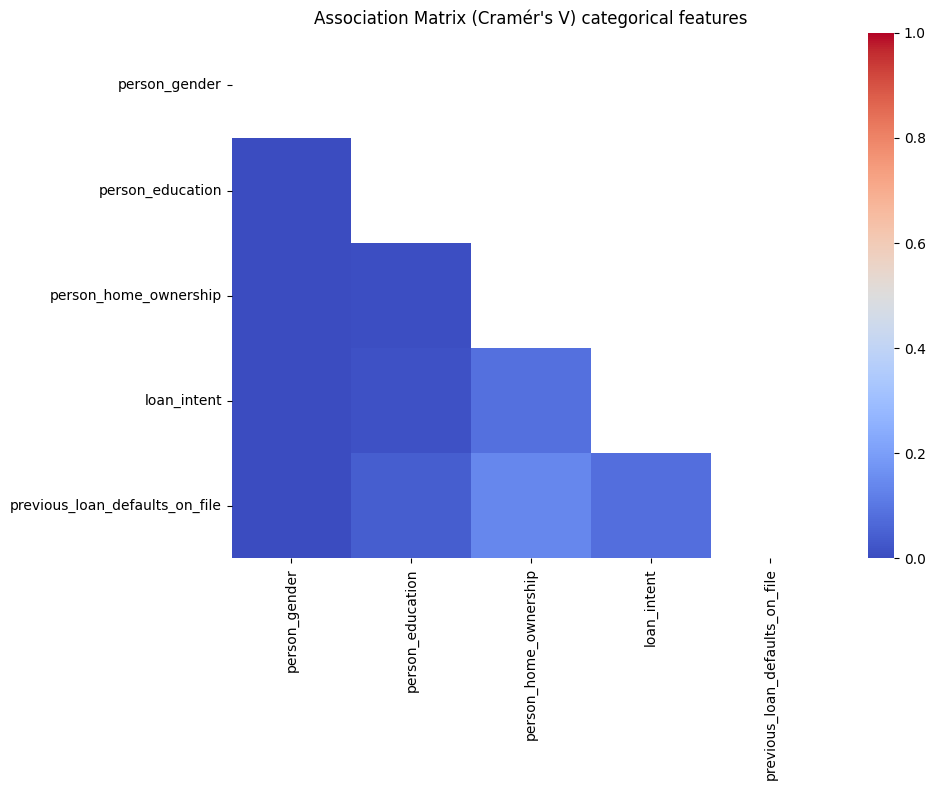

In [3]:
# ==================
# 4) EDA ESSENZIALE (corretto)
# ==================
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import chi2_contingency

# Distribuzione target
ax = df_work[TARGET].value_counts().sort_index().plot(kind='bar')
_ = ax.set_title('Distribuzione target'), ax.set_xlabel('Class'), ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

# Missingness % per colonna (primi 20)
miss = df_work.isna().mean().sort_values(ascending=False)
display(miss.head(20).to_frame('missing_ratio'))

# Cardinalità variabili categoriche
cat_cols = df_work.select_dtypes(include=["object", "category"]).columns.tolist()
print("\nCardinalità variabili categoriche:")
card = pd.Series({c: df_work[c].nunique(dropna=False) for c in cat_cols}).sort_values(ascending=False)
display(card.to_frame("n_unique"))

# Statistiche descrittive numeriche + outlier check
num_cols = df_work.select_dtypes(include=[np.number]).columns.drop([TARGET], errors="ignore").tolist()
print("\nStatistiche descrittive numeriche:")
display(df_work[num_cols].describe().T)

# Correlazioni numeriche (con target se numerico)
if pd.api.types.is_numeric_dtype(df_work[TARGET]):
    corr = df_work[num_cols + [TARGET]].corr(numeric_only=True)
    print("\nCorrelazione con il target (numeriche):")
    target_corr = corr[TARGET].drop(index=[TARGET]).sort_values(ascending=False)
    display(target_corr.to_frame("corr_with_target").head(20))

    plt.figure(figsize=(11, 9))
    sns.heatmap(corr, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": .7})
    plt.title("Correlation Matrix (numerical features)")
    plt.tight_layout()
    plt.show()

    # Heatmap più leggibile (solo correlazioni assolute)
    plt.figure(figsize=(10, 8))
    top_corr = df_work[num_cols].corr(numeric_only=True).abs()
    mask = np.triu(np.ones_like(top_corr, dtype=bool))
    sns.heatmap(top_corr, mask=mask, cmap="coolwarm", annot=False, cbar=True)
    plt.title("Matrice di correlazione (assoluta)")
    plt.tight_layout()
    plt.show()

    # Coppie altamente correlate
    high_pair = []
    for i, c1 in enumerate(num_cols):
        for c2 in num_cols[i+1:]:
            r = corr.loc[c1, c2]
            if abs(r) >= 0.95:
                high_pair.append((c1, c2, r))
    if high_pair:
        print("\nCoppie di feature altamente correlate (|r|>=0.95):")
        display(pd.DataFrame(high_pair, columns=["feat1", "feat2", "corr"]).sort_values("corr", ascending=False))
    else:
        print("\nNessuna coppia di feature con |correlazione| ≥ 0.95.")
else:
    print("\nIl target non è numerico → salta correlazione con il target.")

# Associazioni tra categoriche (Cramér's V)
if len(cat_cols) > 1:
    def cramers_v(x, y):
        confusion = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion)[0]
        n = confusion.sum().sum()
        phi2 = chi2 / n
        r, k = confusion.shape
        # correzione bias per tabelle piccole/non quadrate
        phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
        rcorr = r - (r-1)**2/(n-1)
        kcorr = k - (k-1)**2/(n-1)
        denom = min((kcorr-1), (rcorr-1))
        return np.sqrt(phi2corr / denom) if denom > 0 else 0

    cramer_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
    for c1 in cat_cols:
        for c2 in cat_cols:
            cramer_matrix.loc[c1, c2] = 1.0 if c1 == c2 else cramers_v(df_work[c1], df_work[c2])

    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(cramer_matrix, dtype=bool))
    sns.heatmap(cramer_matrix, mask=mask, cmap="coolwarm", vmin=0, vmax=1, cbar=True)
    plt.title("Association Matrix (Cramér's V) categorical features")
    plt.tight_layout()
    plt.show()
else:
    print("\nPoche o nessuna variabile categorica → salta Cramér's V.")


In [4]:

#elimino al colonna estremamemente predittiva
drop_cols = ["previous_loan_defaults_on_file"]
df_work = df_work.drop(columns=drop_cols)
print("Shape dopo esclusione colonne:", df_work.shape)

Shape dopo esclusione colonne: (45000, 13)


In [ ]:
# =====================
# Feature Engineering
# =====================

# 1) Age buckets (age groups)
# Motivation: risk profile may vary across age groups (young/old borrowers riskier).
if 'person_age' in df_work.columns:
    df_work['person_age_bin'] = pd.cut(
        df_work['person_age'],
        bins=[0, 25, 35, 50, np.inf],
        labels=['<25', '25-35', '35-50', '50+']
    )

# 2) income_to_loan = income / loan amount
# Motivation: measures how many times the annual income covers the loan amount.
if {'person_income', 'loan_amnt'}.issubset(df_work.columns):
    with np.errstate(divide='ignore', invalid='ignore'):
        df_work['income_to_loan'] = (df_work['person_income'] / df_work['loan_amnt']).replace([np.inf, -np.inf], np.nan)

# 3) emp_exp_x_age = work experience relative to age
# Motivation: captures career consistency (high ratio = more solid work history for given age).
if {'person_emp_exp', 'person_age'}.issubset(df_work.columns):
    with np.errstate(divide='ignore', invalid='ignore'):
        df_work['emp_exp_x_age'] = (df_work['person_emp_exp'] / df_work['person_age']).replace([np.inf, -np.inf], np.nan)

# 4) loan_over_score = loan amount / credit score
# Motivation: proxy of the "weight" of the loan relative to creditworthiness.
if {'loan_amnt', 'credit_score'}.issubset(df_work.columns):
    with np.errstate(divide='ignore', invalid='ignore'):
        df_work['loan_over_score'] = (df_work['loan_amnt'] / df_work['credit_score']).replace([np.inf, -np.inf], np.nan)

# 5) loan_int_rate_bin = interest rate groups
# Motivation: higher rates are usually assigned to riskier borrowers.
if 'loan_int_rate' in df_work.columns:
    df_work['loan_int_rate_bin'] = pd.cut(
        df_work['loan_int_rate'],
        bins=[-np.inf, 10, 15, 20, np.inf],
        labels=['<10%', '10-15%', '15-20%', '20%+']
    )

print("New engineered features added")


New engineered features added:


In [6]:
# =====================
# Automatic skewness check and log-transform (replace mode)
# =====================
from scipy.stats import skew
import numpy as np

def auto_log_transform_replace(df, exclude_cols=None, skew_threshold=1.0):
    """
    Automatically log-transform skewed numeric features (replace original columns).
    
    Parameters:
    - df: pd.DataFrame
    - exclude_cols: list of columns to ignore (e.g. target)
    - skew_threshold: absolute skewness above which log-transform is applied
    
    Returns:
    - df: updated DataFrame with replaced log-transformed features
    - skewness: Series with skew values
    - candidates: list of transformed features
    """
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if exclude_cols:
        num_cols = [c for c in num_cols if c not in exclude_cols]
    
    skewness = df[num_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    candidates = skewness[(skewness > skew_threshold) | (skewness < -skew_threshold)].index.tolist()
    
    print("📊 Skewness of numeric features:")
    display(skewness.to_frame("skewness"))
    print(f"\n🔎 Applying log-transform (replacing originals): {candidates}")
    
    for col in candidates:
        if (df[col] <= 0).any():
            df[col] = np.log1p(df[col] - df[col].min() + 1)
        else:
            df[col] = np.log1p(df[col])
    
    return df, skewness, candidates

# Run replacement version
df_work, skewness, log_candidates = auto_log_transform_replace(df_work, exclude_cols=[TARGET])


📊 Skewness of numeric features:


,skewness
income_to_loan,40.999871
person_income,34.136445
person_emp_exp,2.594831
person_age,2.548069
cb_person_cred_hist_length,1.631666
loan_over_score,1.227451
loan_amnt,1.179692
loan_percent_income,1.034478
emp_exp_x_age,0.721614
loan_int_rate,0.213777



🔎 Applying log-transform (replacing originals): ['income_to_loan', 'person_income', 'person_emp_exp', 'person_age', 'cb_person_cred_hist_length', 'loan_over_score', 'loan_amnt', 'loan_percent_income']


In [7]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTENC

# ===========================
# Scoring metrics
# ===========================
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': 'roc_auc',                # built-in scorer, avoids NaN
    'pr_auc': 'average_precision'        # PR AUC = Average Precision
}

# ===========================
# Models to evaluate
# ===========================
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, solver="liblinear"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight="balanced"),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1, class_weight="balanced"),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42, auto_class_weights="Balanced")
}


In [8]:
# ===========================
# Column selection
# ===========================
TARGET = "loan_status"

categorical_features = df_work.select_dtypes(include=["object", "category"]).columns.tolist()
categorical_features = [c for c in categorical_features if c != TARGET]

numerical_features = df_work.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [c for c in numerical_features if c != TARGET]

print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)

# ===========================
# Transformers
# ===========================
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


Categorical features: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'person_age_bin', 'loan_int_rate_bin']
Numerical features: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'income_to_loan', 'emp_exp_x_age', 'loan_over_score']


In [23]:
# Controllo numero di categorie uniche per ogni colonna categorica
print("Cardinalità variabili categoriche:\n")
for col in categorical_features:
    nunique = df_work[col].nunique(dropna=False)
    print(f"{col:30} -> {nunique} categorie uniche")


Cardinalità variabili categoriche:

person_gender                  -> 2 categorie uniche
person_education               -> 5 categorie uniche
person_home_ownership          -> 4 categorie uniche
loan_intent                    -> 6 categorie uniche
person_age_bin                 -> 4 categorie uniche
loan_int_rate_bin              -> 3 categorie uniche


In [9]:
# ===========================
# Baseline pipeline (no SMOTENC)
# ===========================
pipelines_no_smote = {
    name: Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    for name, model in models.items()
}


In [10]:
""" Perché NON usare SMOTENC dentro la pipeline

Quando metti SMOTENC come step della pipeline, gli arriva il dataset prima dell’OHE.

Ma quel dataset contiene ancora stringhe (female, RENT, MEDICAL, …).

SMOTENC non sa gestire stringhe: vuole feature numeriche, e vuole sapere quali indici trattare come categoriche.

Risultato: errore "could not convert string to float: 'female'".


 Perché usare SMOTENC fuori dalla pipeline

Lo applichi direttamente su X_train, y_train grezzi (categoriche in formato originale).

Gli dici quali colonne sono categoriche (cat_indices).

SMOTENC genera un nuovo dataset bilanciato (X_train_smote, y_train_smote) mantenendo numeriche e categoriche in formato comprensibile.

Poi, solo dopo, passi questi dati bilanciati dentro la pipeline che ha OHE + scaler + modello."""



# ===========================
# Train/test split + SMOTENC (outside pipeline)
# ===========================
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC

# Train/test split
X = df_work.drop(columns=[TARGET])
y = df_work[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Indices of categorical features for SMOTENC
cat_indices = [X_train.columns.get_loc(c) for c in categorical_features]

# Apply SMOTENC on training data
smote = SMOTENC(categorical_features=cat_indices, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Original training size:", X_train.shape, " → After SMOTENC:", X_train_smote.shape)

# We reuse the same pipelines defined above (pipelines_no_smote)
# For SMOTE evaluation, we will fit them on (X_train_smote, y_train_smote)
pipelines_smote = pipelines_no_smote.copy()


Original training size: (36000, 17)  → After SMOTENC: (56000, 17)


In [11]:
# ===========================
# Evaluation
# ===========================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_no_smote = {}
results_smote = {}

# Evaluation without SMOTE (on original train set)
for name, pipe in pipelines_no_smote.items():
    cv_results = cross_validate(pipe, X_train, y_train,
                                cv=cv, scoring=scorers, n_jobs=-1, error_score="raise")
    results_no_smote[name] = {m: (np.mean(scores), np.std(scores)) for m, scores in cv_results.items() if m.startswith("test_")}

# Evaluation with SMOTE (on oversampled train set)
for name, pipe in pipelines_smote.items():
    cv_results = cross_validate(pipe, X_train_smote, y_train_smote,
                                cv=cv, scoring=scorers, n_jobs=-1, error_score="raise")
    results_smote[name] = {m: (np.mean(scores), np.std(scores)) for m, scores in cv_results.items() if m.startswith("test_")}



In [12]:
import pandas as pd

def format_results(results_dict):
    rows = []
    for model, metrics in results_dict.items():
        row = {"Model": model}
        for k, (mean, std) in metrics.items():
            metric = k.replace("test_", "")
            row[metric] = f"{mean:.3f} [{std:.3f}]"
        rows.append(row)
    return pd.DataFrame(rows)

print("=== Results without SMOTENC ===")
display(format_results(results_no_smote))

print("=== Results with SMOTENC ===")
display(format_results(results_smote))


=== Results without SMOTENC ===


,Model,accuracy,precision,recall,f1,roc_auc,pr_auc
0,Logistic Regression,0.858 [0.004],0.758 [0.013],0.528 [0.007],0.622 [0.009],0.869 [0.005],0.715 [0.005]
1,Random Forest,0.906 [0.002],0.913 [0.009],0.640 [0.010],0.752 [0.007],0.920 [0.006],0.853 [0.009]
2,XGBoost,0.913 [0.004],0.894 [0.009],0.692 [0.010],0.780 [0.010],0.934 [0.003],0.873 [0.006]
3,LightGBM,0.888 [0.004],0.733 [0.006],0.784 [0.016],0.757 [0.010],0.932 [0.005],0.869 [0.007]
4,CatBoost,0.893 [0.002],0.745 [0.006],0.788 [0.009],0.766 [0.005],0.934 [0.003],0.873 [0.006]


=== Results with SMOTENC ===


,Model,accuracy,precision,recall,f1,roc_auc,pr_auc
0,Logistic Regression,0.821 [0.002],0.820 [0.004],0.823 [0.004],0.822 [0.002],0.903 [0.002],0.906 [0.002]
1,Random Forest,0.909 [0.003],0.936 [0.004],0.879 [0.003],0.906 [0.003],0.966 [0.001],0.970 [0.001]
2,XGBoost,0.939 [0.001],0.968 [0.002],0.908 [0.002],0.937 [0.001],0.980 [0.000],0.984 [0.000]
3,LightGBM,0.937 [0.001],0.969 [0.003],0.903 [0.002],0.935 [0.001],0.978 [0.001],0.983 [0.000]
4,CatBoost,0.943 [0.002],0.975 [0.002],0.909 [0.003],0.941 [0.002],0.980 [0.001],0.985 [0.001]


=== Feature Importances with SMOTENC ===


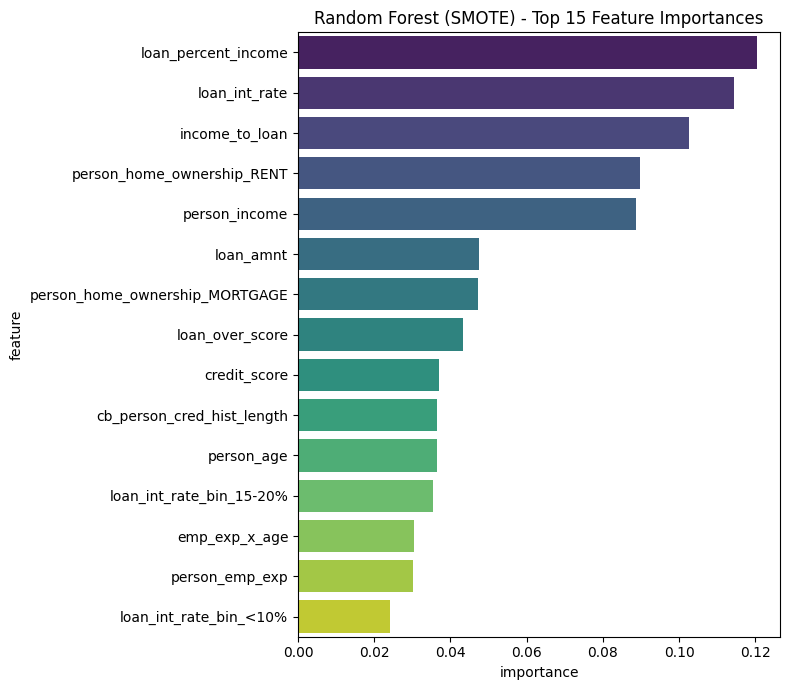

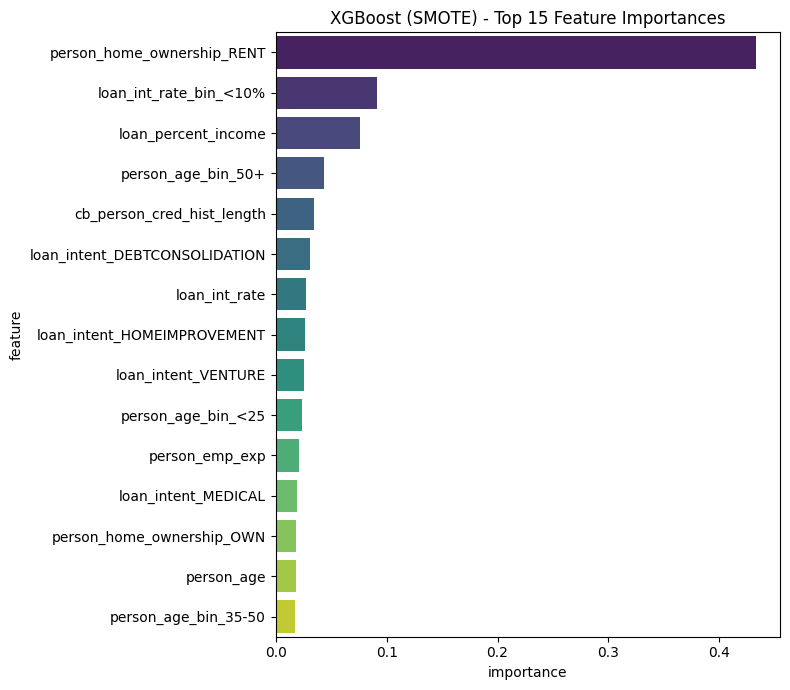

[LightGBM] [Info] Number of positive: 28000, number of negative: 28000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2828
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


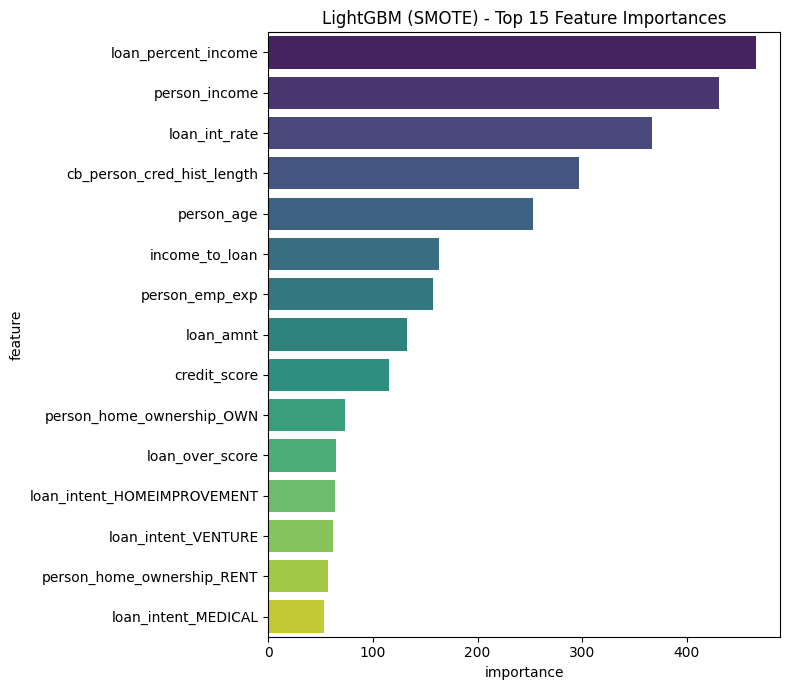

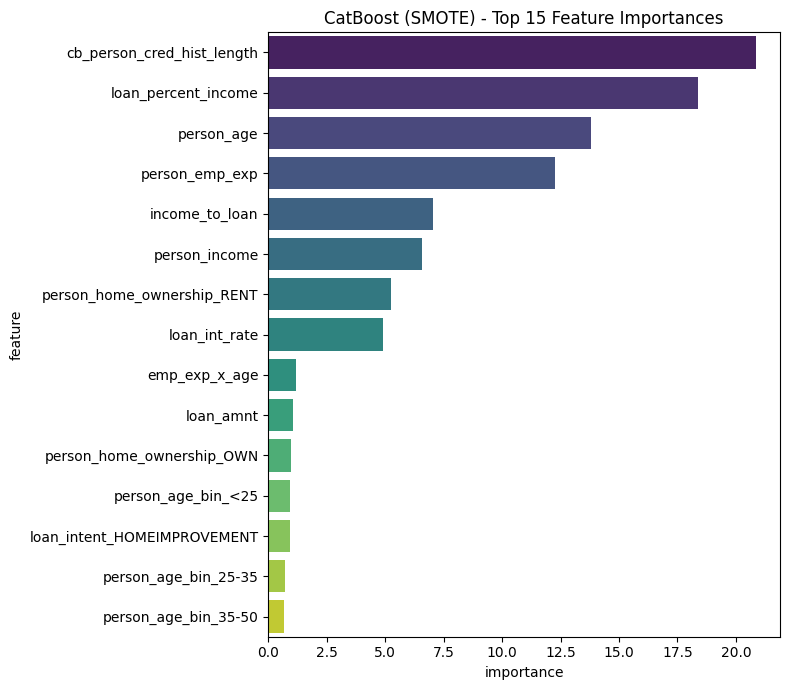

=== Feature Importances without SMOTENC ===


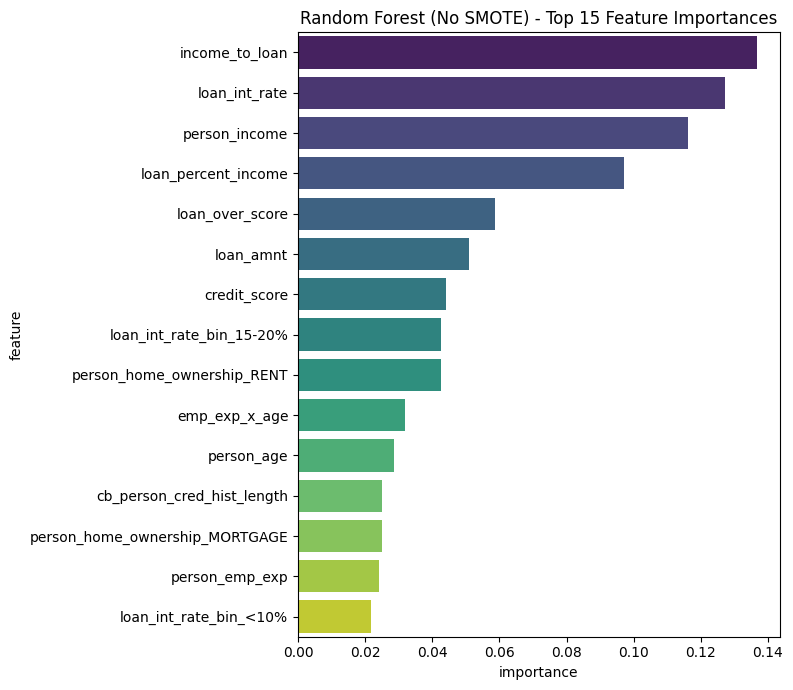

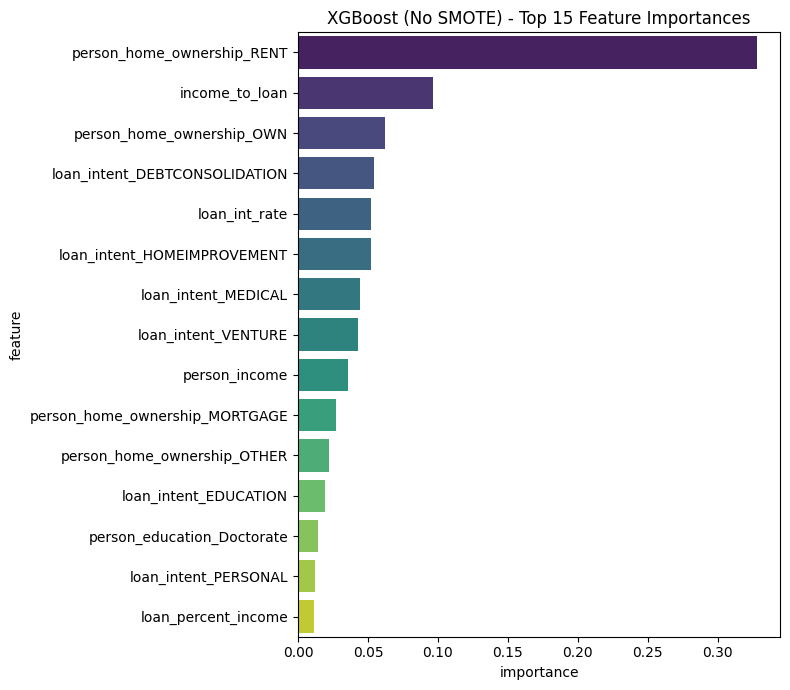

[LightGBM] [Info] Number of positive: 8000, number of negative: 28000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2000
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


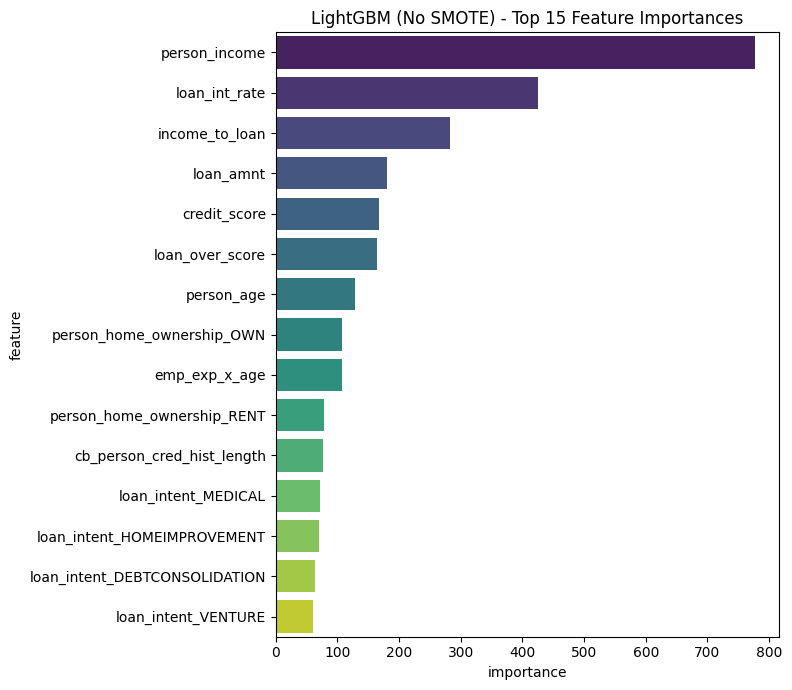

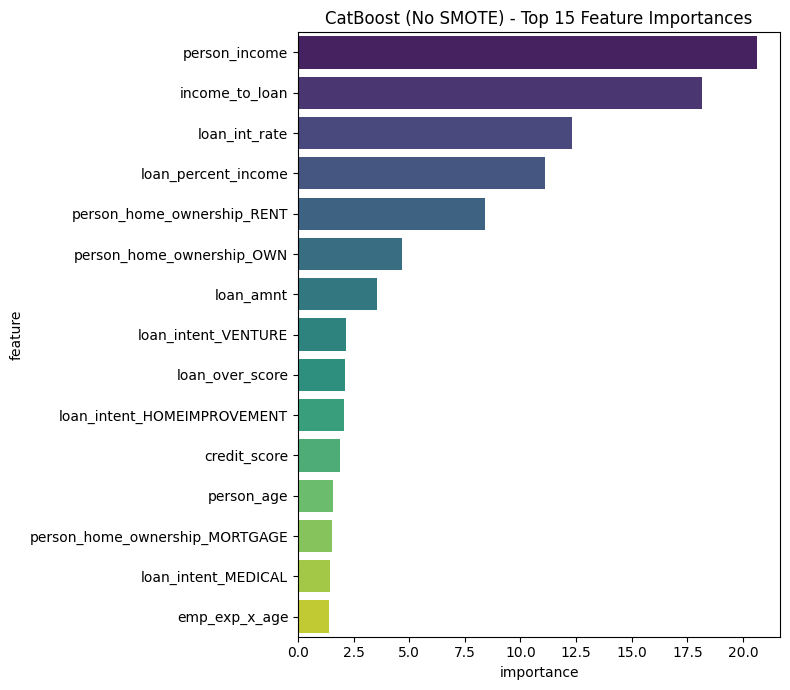

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_feature_importances(model, feature_names, model_name, top_n=15):
    """
    Plot top_n feature importances for tree-based models.
    """
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif model.__class__.__name__ == "CatBoostClassifier":
        importances = model.get_feature_importance()
    else:
        raise ValueError(f"Model {model_name} does not provide feature importances.")
    
    df_imp = pd.DataFrame({"feature": feature_names, "importance": importances})
    df_imp = df_imp.sort_values("importance", ascending=False).head(top_n)

    plt.figure(figsize=(8, top_n * 0.4 + 1))
    sns.barplot(x="importance", y="feature", data=df_imp, palette="viridis")
    plt.title(f"{model_name} - Top {top_n} Feature Importances")
    plt.tight_layout()
    plt.show()


# ===========================
# Function to train & plot importances for all models
# ===========================
def feature_importance_all_models(X, y, numerical_features, categorical_features, preprocessor, top_n=15, title_suffix=""):
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight="balanced"),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, n_jobs=-1),
        "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1, class_weight="balanced"),
        "CatBoost": CatBoostClassifier(verbose=0, random_state=42, auto_class_weights="Balanced")
    }

    # Fit each model on given data
    for name, clf in models.items():
        pipe = Pipeline([("preprocessor", preprocessor), ("classifier", clf)])
        pipe.fit(X, y)

        # Get feature names (after preprocessing)
        ohe = pipe.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"]
        cat_feats = list(ohe.get_feature_names_out(categorical_features))
        all_features = numerical_features + cat_feats

        # Extract classifier inside pipeline
        model_inside = pipe.named_steps["classifier"]

        # Plot
        plot_feature_importances(model_inside, all_features, f"{name} {title_suffix}", top_n=top_n)


# ===========================
# Run for SMOTE version
# ===========================
print("=== Feature Importances with SMOTENC ===")
feature_importance_all_models(X_train_smote, y_train_smote, numerical_features, categorical_features, preprocessor, top_n=15, title_suffix="(SMOTE)")

# ===========================
# Run for NO SMOTE version
# ===========================
print("=== Feature Importances without SMOTENC ===")
feature_importance_all_models(X_train, y_train, numerical_features, categorical_features, preprocessor, top_n=15, title_suffix="(No SMOTE)")


[LightGBM] [Info] Number of positive: 8000, number of negative: 28000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2000
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


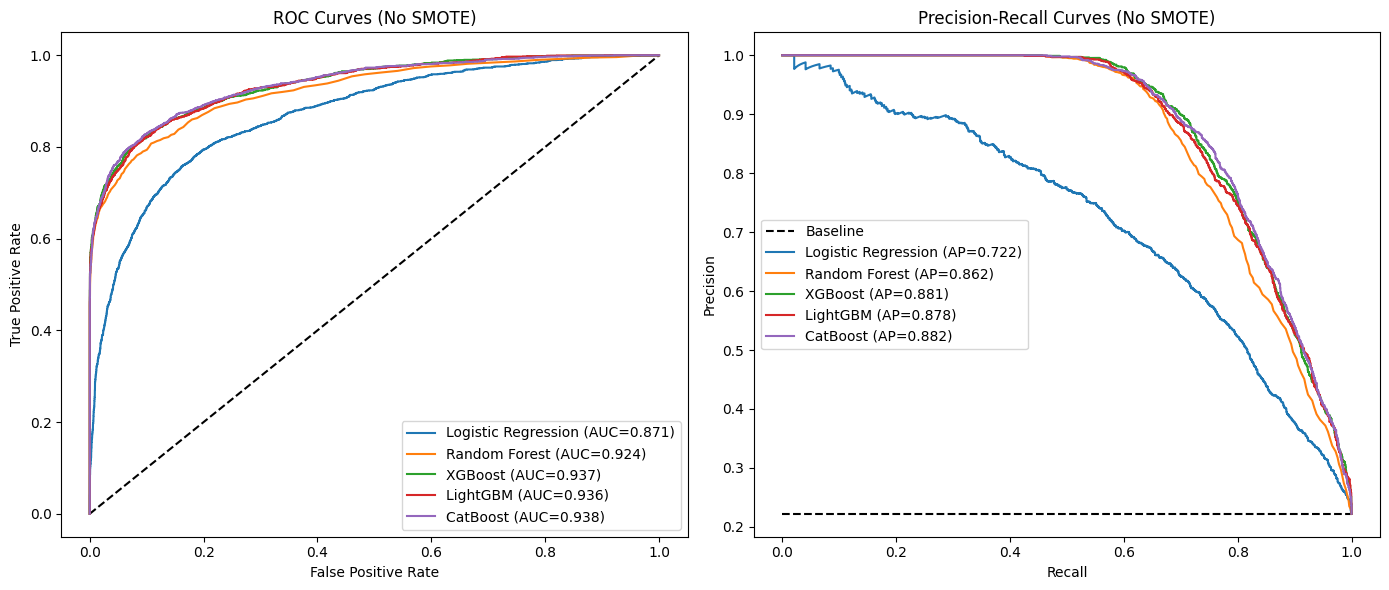

[LightGBM] [Info] Number of positive: 28000, number of negative: 28000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2828
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


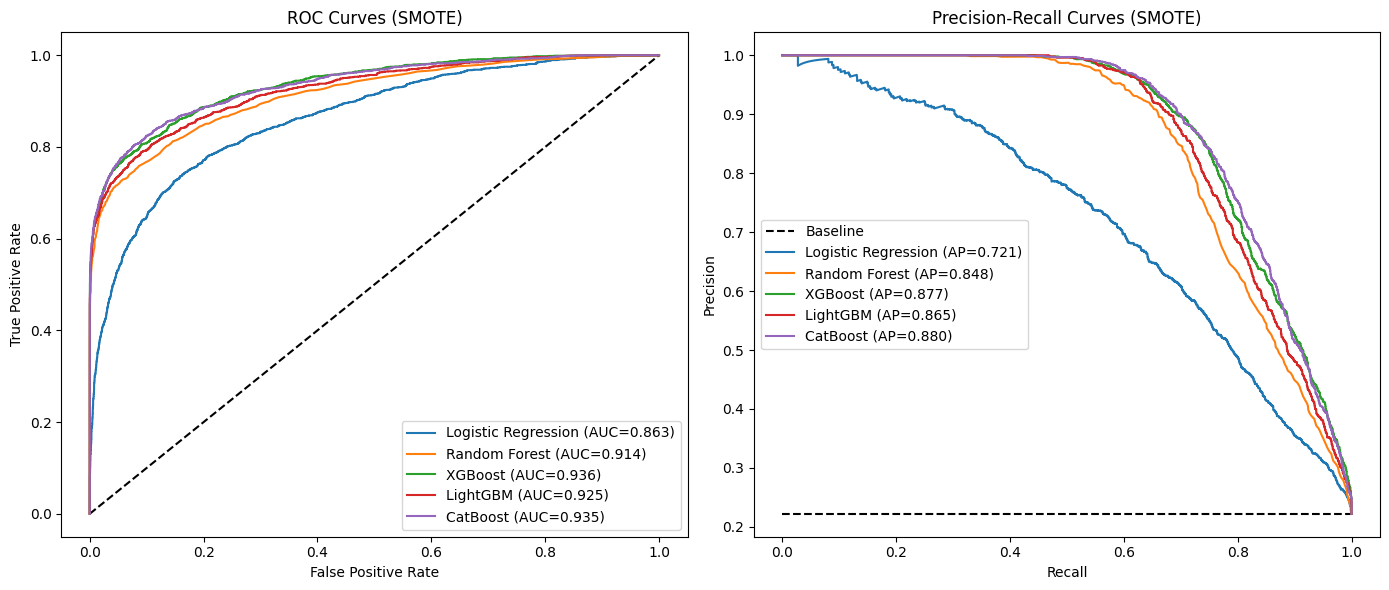

,Model,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC,Variant
0,Logistic Regression,0.859,0.759,0.534,0.627,0.871,0.722,No SMOTE
1,Random Forest,0.911,0.928,0.649,0.764,0.924,0.862,No SMOTE
2,XGBoost,0.915,0.914,0.682,0.781,0.937,0.881,No SMOTE
3,LightGBM,0.894,0.741,0.802,0.771,0.936,0.878,No SMOTE
4,CatBoost,0.900,0.760,0.800,0.780,0.938,0.882,No SMOTE
0,Logistic Regression,0.804,0.543,0.754,0.631,0.863,0.721,SMOTE
1,Random Forest,0.897,0.792,0.725,0.757,0.914,0.848,SMOTE
2,XGBoost,0.916,0.893,0.708,0.790,0.936,0.877,SMOTE
3,LightGBM,0.911,0.885,0.691,0.776,0.925,0.865,SMOTE
4,CatBoost,0.916,0.913,0.688,0.785,0.935,0.880,SMOTE


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, precision_recall_curve,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)
import pandas as pd

# ===========================
# Funzione valutazione + grafici
# ===========================
def evaluate_and_plot(models, X_train, y_train, X_test, y_test, preprocessor, tag="No SMOTE"):
    results = []
    plt.figure(figsize=(14, 6))

    # Subplot ROC e PR
    plt.subplot(1, 2, 1)
    plt.title(f"ROC Curves ({tag})")
    plt.plot([0, 1], [0, 1], "k--")

    plt.subplot(1, 2, 2)
    plt.title(f"Precision-Recall Curves ({tag})")
    plt.plot([0, 1], [sum(y_test)/len(y_test)]*2, "k--", label="Baseline")

    for name, model in models.items():
        pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", model)
        ])
        # Train
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, "predict_proba") else None

        # Metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
        pr_auc = average_precision_score(y_test, y_proba) if y_proba is not None else None

        results.append({
            "Model": name,
            "Accuracy": round(acc, 3),
            "Precision": round(prec, 3),
            "Recall": round(rec, 3),
            "F1": round(f1, 3),
            "ROC_AUC": round(roc_auc, 3) if roc_auc else "NA",
            "PR_AUC": round(pr_auc, 3) if pr_auc else "NA",
            "Variant": tag
        })

        # === ROC curve ===
        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            plt.subplot(1, 2, 1)
            plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

        # === PR curve ===
        if y_proba is not None:
            precision, recall, _ = precision_recall_curve(y_test, y_proba)
            plt.subplot(1, 2, 2)
            plt.plot(recall, precision, label=f"{name} (AP={pr_auc:.3f})")

    # Finalizza grafici
    plt.subplot(1, 2, 1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(results)

# ===========================
# Esecuzione con e senza SMOTE
# ===========================
results_holdout_no_smote = evaluate_and_plot(
    models, X_train, y_train, X_test, y_test, preprocessor, tag="No SMOTE"
)

results_holdout_smote = evaluate_and_plot(
    models, X_train_smote, y_train_smote, X_test, y_test, preprocessor, tag="SMOTE"
)

# Unione risultati
results_holdout = pd.concat([results_holdout_no_smote, results_holdout_smote])
display(results_holdout)


## Grid Search for the 3 best models (with SMOTENC paramerters)

In [20]:
from grid_params import rf_params
from sklearn.model_selection import GridSearchCV

# Random Forest pipeline
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_pipe = Pipeline([("preprocessor", preprocessor), ("classifier", rf)])

scoring = {
    "roc_auc": "roc_auc",
    "f1": "f1",
    "f1_macro": "f1_macro",
    "precision": "precision",
    "recall": "recall"
}

rf_grid = GridSearchCV(
    rf_pipe,
    param_grid=rf_params,
    scoring=scoring,
    refit="recall",   # prioritizziamo RECALL
    cv=5,
    n_jobs=-1,
    verbose=2
)

rf_grid.fit(X_train_smote, y_train_smote)

print("Best Recall:", rf_grid.best_score_)
print("Best Params:", rf_grid.best_params_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

In [ ]:
from grid_params import xgb_params
from xgboost import XGBClassifier

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb_pipe = Pipeline([("preprocessor", preprocessor), ("classifier", xgb)])

xgb_grid = GridSearchCV(
    xgb_pipe,
    param_grid=xgb_params,
    scoring=scoring,
    refit="recall",
    cv=5,
    n_jobs=-1,
    verbose=2
)

xgb_grid.fit(X_train_smote, y_train_smote)

print("Best Recall:", xgb_grid.best_score_)
print("Best Params:", xgb_grid.best_params_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Recall: 0.8991071428571429
Best Params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 600, 'classifier__subsample': 0.8}


In [ ]:
from grid_params import cat_params
from catboost import CatBoostClassifier

cat = CatBoostClassifier(
    verbose=0,
    random_state=42
)

cat_pipe = Pipeline([("preprocessor", preprocessor), ("classifier", cat)])

cat_grid = GridSearchCV(
    cat_pipe,
    param_grid=cat_params,
    scoring=scoring,
    refit="recall",
    cv=5,
    n_jobs=-1,
    verbose=2
)

cat_grid.fit(X_train_smote, y_train_smote)

print("Best Recall:", cat_grid.best_score_)
print("Best Params:", cat_grid.best_params_)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Recall: 0.8934642857142858
Best Params: {'classifier__depth': 10, 'classifier__iterations': 600, 'classifier__l2_leaf_reg': 7, 'classifier__learning_rate': 0.1}


In [ ]:
import json

# Supponendo che tu abbia già eseguito le grid search:
# grid_rf, grid_xgb, grid_cat = GridSearchCV(...).fit(...)

best_params_all = {
    "RandomForest": rf_grid.best_params_,
    "XGBoost": xgb_grid.best_params_,
    "CatBoost": cat_grid.best_params_
}

# Salva su file JSON
with open("best_params_F1.json", "w") as f:
    json.dump(best_params_all, f, indent=4)

print("Best parameters salvati in best_params.json")


Best parameters salvati in best_params.json


,Model,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC
0,Random Forest,0.896667,0.791394,0.7265,0.757560,0.914987,0.850043
1,XGBoost,0.917333,0.890547,0.7160,0.793792,0.939369,0.886846
2,CatBoost,0.915889,0.899678,0.6995,0.787060,0.932917,0.875340


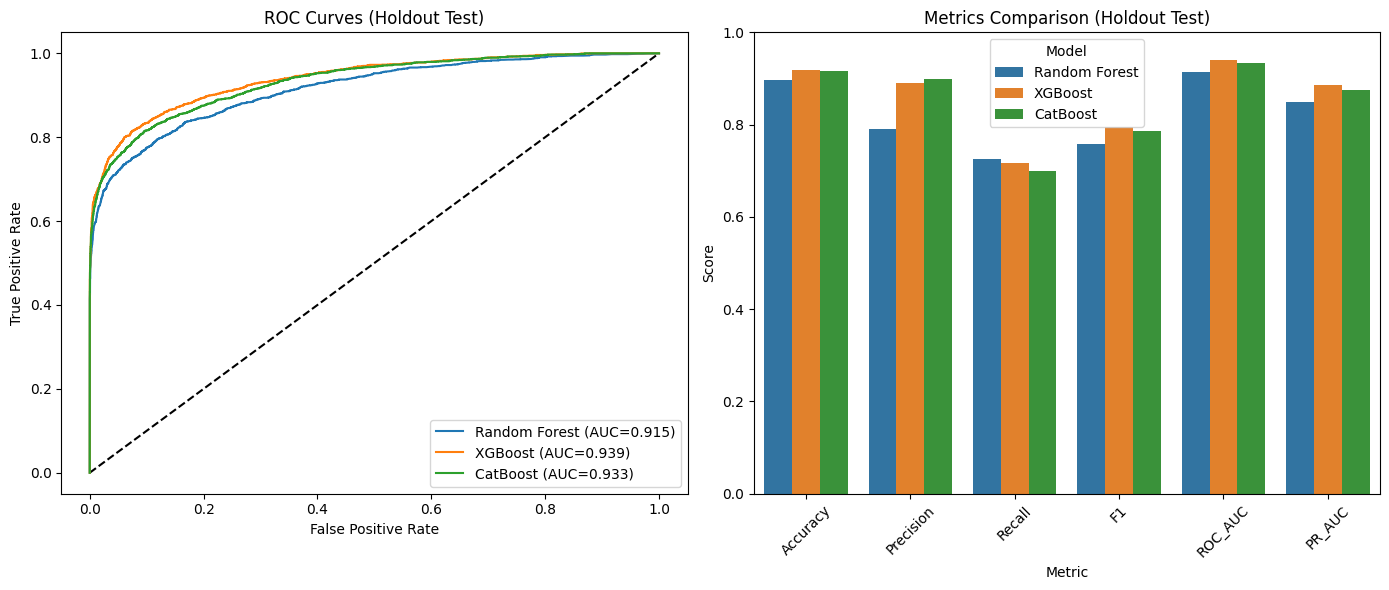

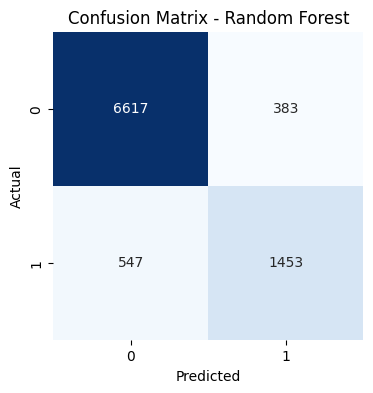

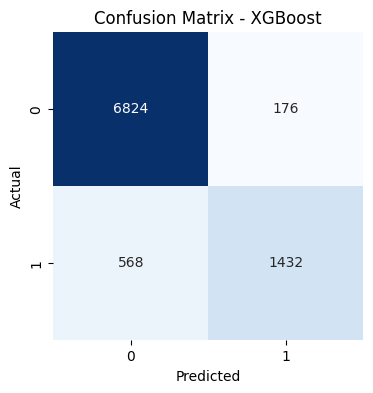

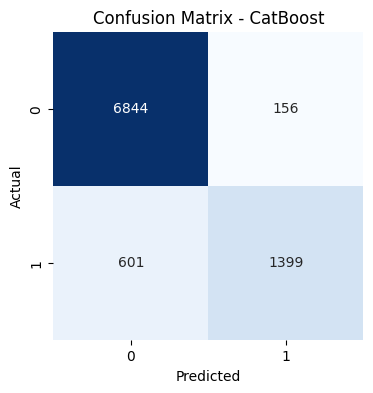

In [21]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve, confusion_matrix
)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline

# ===========================
# 1) Load best params
# ===========================
with open("best_params.json", "r") as f:
    best_params_all = json.load(f)

# Helper to strip pipeline prefix
def strip_params(params):
    return {k.replace("classifier__", ""): v for k, v in params.items()}

# ===========================
# 2) Rebuild models with best params
# ===========================
rf_best = RandomForestClassifier(**strip_params(best_params_all["RandomForest"]),
                                 random_state=42, n_jobs=-1, class_weight="balanced")

xgb_best = XGBClassifier(**strip_params(best_params_all["XGBoost"]),
                         use_label_encoder=False, eval_metric="logloss",
                         random_state=42, n_jobs=-1)

cat_best = CatBoostClassifier(**strip_params(best_params_all["CatBoost"]),
                              verbose=0, random_state=42, auto_class_weights="Balanced")

models_best = {
    "Random Forest": rf_best,
    "XGBoost": xgb_best,
    "CatBoost": cat_best
}

# ===========================
# 3) Train on SMOTENC data
# ===========================
results = []
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.title("ROC Curves (Holdout Test)")
plt.plot([0,1],[0,1],"k--")

for name, model in models_best.items():
    pipe = Pipeline([("preprocessor", preprocessor), ("classifier", model)])
    pipe.fit(X_train_smote, y_train_smote)

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC_AUC": roc_auc,
        "PR_AUC": pr_auc
    })

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# ===========================
# 4) Metrics summary
# ===========================
df_results = pd.DataFrame(results)
display(df_results)

# ===========================
# 5) Barplot metrics
# ===========================
plt.subplot(1,2,2)
metrics_to_plot = ["Accuracy","Precision","Recall","F1","ROC_AUC","PR_AUC"]
df_melt = df_results.melt(id_vars="Model", value_vars=metrics_to_plot, var_name="Metric", value_name="Score")
sns.barplot(x="Metric", y="Score", hue="Model", data=df_melt)
plt.title("Metrics Comparison (Holdout Test)")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.tight_layout()
plt.show()

# ===========================
# 6) Confusion matrices
# ===========================
for name, model in models_best.items():
    pipe = Pipeline([("preprocessor", preprocessor), ("classifier", model)])
    pipe.fit(X_train_smote, y_train_smote)
    y_pred = pipe.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [ ]:



################################# QUESTA RUIVEDILA  ####################################################


"""
import pandas as pd

# Funzione helper per estrarre i risultati migliori
def extract_results(grid, model_name):
    return {
        "Model": model_name,
        "Best Params": grid.best_params_,
        "Best Recall": grid.cv_results_['mean_test_recall'][grid.best_index_],
        "Best Precision": grid.cv_results_['mean_test_precision'][grid.best_index_],
        "Best F1-macro": grid.cv_results_['mean_test_f1_macro'][grid.best_index_],
        "Best ROC_AUC": grid.cv_results_['mean_test_roc_auc'][grid.best_index_]
    }

results = []
results.append(extract_results(rf_grid, "Random Forest"))
results.append(extract_results(xgb_grid, "XGBoost"))
results.append(extract_results(cat_grid, "CatBoost"))

df_results = pd.DataFrame(results)
display(df_results)
"""

'\nimport pandas as pd\n\n# Funzione helper per estrarre i risultati migliori\ndef extract_results(grid, model_name):\n    return {\n        "Model": model_name,\n        "Best Params": grid.best_params_,\n        "Best Recall": grid.cv_results_[\'mean_test_recall\'][grid.best_index_],\n        "Best Precision": grid.cv_results_[\'mean_test_precision\'][grid.best_index_],\n        "Best F1-macro": grid.cv_results_[\'mean_test_f1_macro\'][grid.best_index_],\n        "Best ROC_AUC": grid.cv_results_[\'mean_test_roc_auc\'][grid.best_index_]\n    }\n\nresults = []\nresults.append(extract_results(rf_grid, "Random Forest"))\nresults.append(extract_results(xgb_grid, "XGBoost"))\nresults.append(extract_results(cat_grid, "CatBoost"))\n\ndf_results = pd.DataFrame(results)\ndisplay(df_results)\n'


# =======================================
# 12) SALVATAGGIO PIPELINE MIGLIORE (JOBLIB)
# =======================================
import joblib, os
out_dir = Path('Models')
out_dir.mkdir(exist_ok=True)
if chosen is not None:
    out_path = out_dir / f'best_pipeline_{chosen_name}.joblib'
    joblib.dump(chosen, out_path)
    print('Salvato:', out_path)
else:
    print('Nessun modello da salvare.')
